In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# MSTICpy at Blackhat Arsenal 2020

## Setup

MSTICpy includes a feature called [nbinit](https://msticpy.readthedocs.io/en/latest/msticpy.nbtools.html?highlight=nbinit#module-msticpy.nbtools.nbinit) that helps makes the process of installing packages and importing modules into a notebook environment cleaner and easier. This was built to help us standardize notebook setup.<br>
By passing the notebook namespace to init_notebook() this function handles the job of importing core MSTICpy modules along with others that might be needed by a notebook.

<font color='blue'>[ian comment] - I think it might be better to move some of these to their point of use and reduce this list:
1. Folium map is imported in nbinit
2. Foliummap now has a center_map method - you can call this after add the IPs.
3. For items in nbdisplay I think it might be cleaner to call them as nbdisplay.xxx
4. For notebooklets it might be better to have this inline - "now we going to use another package....notebooklets"
(actually we should install this at some point - or have a cell for installing)
5. WIDGET_DEFAULTS is created in nbinit

In [1]:
from msticpy.nbtools import nbinit
extra_imports = [
    "msticpy.nbtools.timeseries, display_timeseries_anomolies",
    "msticpy.analysis.timeseries, timeseries_anomalies_stl",
    "msticpy.nbtools.morph_charts, MorphCharts",
    "datetime, datetime",
    # "msticpy.nbtools.security_alert_graph, create_alert_graph", # Already imported
    # "msticpy.nbtools.security_alert_graph, add_related_alerts", # Already imported
    #"msticpy.nbtools.nbdisplay, draw_alert_entity_graph", # Available as nbdisplay.add_related_alerts
    #"msticpy.nbtools.foliummap, get_map_center", # use center_map
    #"msticpy.nbtools.foliummap, FoliumMap", # Already imported
    "msticpy.sectools.ip_utils, convert_to_ip_entities",
    #"msticnb,,nb",  # import where you need it
    # "msticnb.common, TimeSpan", # could use directly as nb.common.TimeSpan 
    #"datetime, datetime", # duplicate
    "msticpy.nbtools.ti_browser, browse_results",
    "IPython.display, Image",
    "msticpy.sectools.ip_utils, get_whois_info",
    "msticpy.sectools.ip_utils, get_ip_type"
    
]

nbinit.init_notebook(
    namespace=globals(),
    additional_packages=["pyvis"],
    extra_imports=extra_imports,
);

ti = TILookup()

Processing imports....
All packages are already installed
Checking configuration....

The following configuration errors were found: 
 -----------------------------------------------
TIProviders/AzureSentinel: Missing or invalid WorkspaceID.
TIProviders/AzureSentinel: Missing or invalid TenantID.

The following configuration warnings were found: 
 -------------------------------------------------
No AzureCLI section in settings.
Setting options....


Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


## Data Acquisition - Splunk
The starting point for many notebooks is ingesting data to conduct analysis or investigation of. MSTICpy has a number of [query providers](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html) to allow users to query and return data from a number of sources. Below we are using the Splunk query provider to return data from our Splunk instance.<br> 
> Note: Using *Splunk* API via *splunk-sdk* Python package - the MSTICpy Splunk provider is in beta.

Data is returned in a Pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for easy manipulation and to provide a common interface for other features in MSTICpy.<br><br>
Here we are getting a summary of our network traffic  in the time period we are interested in.


In [53]:
splunk_pwd = widgets.Password(description='Splunk Pwd:')
splunk_pwd

Password(description='Splunk Pwd:')

In [50]:
# Initialize a Splunk provider and connect to our Splunk instance.
splunk_prov = QueryProvider("Splunk")
splunk_prov.connect(host="splunk-mstic.westus2.cloudapp.azure.com", username="admin", password=splunk_pwd.value)

connected


In [4]:
# Define a Splunk Query and run it.
splunk_query = "search host=network_sum index=blackhat earliest=0 | table TimeGenerated, TotalBytesSent"

stldemo = splunk_prov.exec_query(splunk_query)
stldemo['TimeGenerated'] = pd.to_datetime(stldemo['TimeGenerated'])
stldemo.set_index('TimeGenerated', inplace=True)
stldemo.sort_index(inplace=True)
stldemo.head()

,TotalBytesSent
TimeGenerated,
2020-07-06 00:00:00+00:00,10823
2020-07-06 01:00:00+00:00,14821
2020-07-06 02:00:00+00:00,13532
2020-07-06 03:00:00+00:00,11947
2020-07-06 04:00:00+00:00,11193


## Timeseries Analysis of detected Anomalies
Once we have queried the data, there are a number of analysis features within MSTICpy to help understand the data and identify potential security incidents. 

In order to effectively hunt in a dataset analysts need to focus on specific events of interest. Below we use MSTICpy's [time series analysis](https://msticpy.readthedocs.io/en/latest/msticpy.analysis.html?highlight=timeseries#module-msticpy.analysis.timeseries) machine learning capabilities to identify anomalies in our network traffic for further investigation.<br>
As well as computing anomalies we visualize the data so that we can more easily see where these anomalies present themselves.

> Note: Visualization powered by *Bokeh*

In [5]:
# Conduct our timeseries analyis
output = timeseries_anomalies_stl(stldemo)
# Visualize the timeseries and any anomalies
display_timeseries_anomolies(data=output, y= 'TotalBytesSent')

Loading BokehJS ...

Column(id='1406', ...)

In [6]:
# Identify when the anomalies occur so that we can use this timnerange to scope the next stage of our investigation.
start = output[output['anomalies']==1]['TimeGenerated'].min()
end = output[output['anomalies']==1]['TimeGenerated'].max() +  pd.to_timedelta(1, unit='h')

# md and md_warn are MSTICpy features to provide simple, and clean output in notebook cells
md(f"Anomalous session start time: {start} - end time: {end}")

## Enrich and Pivot on IP Addresses
With the time series analysis identifying several events of interest we need additional context to be able to effectively conduct a security investigation. MSTICpy has a range of features to help enrich key data types and provide that context depending on the entities being used. <br>
To get these entities, we again query Splunk to get the IP addresses associated with the anomalous traffic.

In [7]:
splunk_query = "search host=network_raw index=blackhat earliest=0 | table TimeGenerated, Action, SourceIP, DestinationIP, TotalBytesSent"
net_data = splunk_prov.exec_query(splunk_query)

# We need to identify what network endpoints are associated with the anomalies
net_data['TotalBytesSent'] = net_data['TotalBytesSent'].astype(int)
grouped_df = net_data.groupby(['SourceIP', 'DestinationIP'])
noisy_hosts = grouped_df['TotalBytesSent'].agg(np.sum).sort_values(ascending=False)
md("Top talkers during anomolous session: ", 'bold')
display(noisy_hosts[:5])
source_ip, dest_ip = noisy_hosts.index[0][0:2]

SourceIP       DestinationIP
20.185.182.48  31.220.60.108    8328
10.16.12.1     40.124.45.19     1004
10.0.3.5       40.124.45.19      621
10.4.5.12      13.71.172.130     247
               40.77.232.95      189
Name: TotalBytesSent, dtype: int32

### Network data enrichment
MSTICpy can help analysts investigate an IP address, using open source information such as [passive DNS](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html?highlight=passive%20dns#use-to-do-a-passive-dns-lookup) data, [IP geolocation](https://msticpy.readthedocs.io/en/latest/data_acquisition/GeoIPLookups.html) and [threat intelligence](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html) feeds to provide valuable context.

> Note: Whois module uses *ipwhois*, TI module uses services from *OTX*, *VirusTotal*, *XForce*, *AzureSentinel*, and *OpenPageRank*

<font color='blue'>[ian comment] - where are you getting the IP Location?

In [56]:
# Get and display WhoIs data
md(f"Target IP: {dest_ip} ({get_ip_type(dest_ip)} IP address)", 'bold')

whois_info = get_whois_info(dest_ip)
md(f'Whois Registrar Info : ASN Owner: {whois_info[0]}', styles=["bold"])
md(f"ASN Address: {whois_info[1]['nets'][0]['address']}")
    
# Get Passive DNS results
psv_dns = ti.lookup_ioc(observable=dest_ip, ico_type="ipv4", ioc_query_type="passivedns", providers=["XForce"])
md(f"Passive DNS records for {dest_ip}:", styles=["bold"])
for res in ti.result_to_df(psv_dns)['RawResult'][0]['Passive']['records']:
    print(res['value']," - ", res['last'])
    
# Lookup ip IPAddress in threat intel feeds
ip_ti = ti.lookup_ioc(observable=dest_ip)
md(f"<br>Threat Intel results for {dest_ip}:", styles=["bold"])
ti.result_to_df(ip_ti)

joblly.com  -  2020-07-09T10:48:00Z
cdn-xhr.com  -  2020-07-09T10:48:00Z
rackxhr.com  -  2020-07-09T10:48:00Z
hixrq.net  -  2020-07-09T10:48:00Z
idpcdn-cloud.com  -  2020-07-09T10:48:00Z
thxrq.com  -  2020-07-09T10:48:00Z
hivnd.net  -  2020-07-09T10:48:00Z


,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
OTX,31.220.60.108,ipv4,None,OTX,True,high,"{'pulse_count': 6, 'names': ['Card Skimmer Found Hitting Vulnerable E-Commerce Sites', 'Credit c...","{'sections': ['general', 'geo', 'reputation', 'url_list', 'passive_dns', 'malware', 'nids_list',...",https://otx.alienvault.com/api/v1/indicators/IPv4/31.220.60.108/general,0
OPR,31.220.60.108,ipv4,None,OPR,False,information,IoC type ipv4 not supported.,None,None,1
Tor,31.220.60.108,ipv4,None,Tor,True,information,Not found.,None,https://check.torproject.org/exit-addresses,0
VirusTotal,31.220.60.108,ipv4,None,VirusTotal,True,high,"{'verbose_msg': 'IP address in dataset', 'response_code': 1, 'detected_urls': ['http://cdn-xhr.c...","{'undetected_urls': [['https://joblly.com/', 'd339002071cb0bf25ceee8f56c009e7bd06970eeab1b58c970...",https://www.virustotal.com/vtapi/v2/ip-address/report,0
XForce,31.220.60.108,ipv4,None,XForce,True,high,"{'score': 7.1, 'cats': {'Malware': 71}, 'categoryDescriptions': {'Malware': 'This category lists...","{'ip': '31.220.60.108', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional ...",https://api.xforce.ibmcloud.com/ipr/31.220.60.108,0


We can visualize the GeoLocation of the IP Address. Below we use [FoliumMap](https://msticpy.readthedocs.io/en/latest/visualization/FoliumMap.html) to plot the IP address location on an interactive map.

> Note: uses the Python *Folium* package, which is a wrapper around *Leafletjs*

In [58]:
# Plot IP geolocation on a map
folium_map = FoliumMap(zoom_start=4)
md('<h3>Location of remote IP</h3>')
folium_map.add_ip_cluster(ip_entities=convert_to_ip_entities(dest_ip), color="red")
folium_map.center_map()
folium_map

## Host Lookup
Once we have some context on our remote IP address we can pivot our investigation to look at the local host that has been communicating with it.

### Data Acquisition from Azure Sentinel
As well as *Splunk*, MSTICpy has a query provider for *Azure Sentinel*. For the next phase of our investigation we are going to use this query provider to acquire data.<br><br>
With the Splunk connection we provided connection details directly to our query provider when calling `.connect()`. We can also store details in a [msticpy configuration file](https://msticpy.readthedocs.io/en/latest/getting_started/msticpyconfig.html) (`msticpyconfig.yaml`) and pass them to the query provider programmatically. Here we use the [Workspace Config](https://msticpy.readthedocs.io/en/latest/msticpy.common.html?highlight=WorkspaceConfig#msticpy.common.wsconfig.WorkspaceConfig) feature to access this configuration and retrieve the items we need to authenticate to Azure Sentinel.

> **Note**: the authentication flow for Azure Sentinel is different from Splunk and use the Oauth2.0 device code process.

In [11]:
# Initalize and connect to Azure Sentinel using details from our config file.
qry_prov = QueryProvider('LogAnalytics')
wkspace = WorkspaceConfig()
qry_prov.connect(wkspace.code_connect_str)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Once connected we can query Azure Sentinel in a similar way to Splunk - by providing a text query string.
<br>We substitute the `source_ip` value we obtained in the previous section *Enrich and Pivot on IP Addresses*

In [59]:
# Query Azure Sentinel to get host details.
query = f"Heartbeat | where ComputerIP == '{source_ip}'"

host = qry_prov.exec_query(query)
host_name = host['Computer'].iloc[0]
md(f"Host to investigate: <b>{host_name}</b>")

<IPython.core.display.Javascript object>

<font color='blue'>[ian comment] - The host name looks like BlackHat Demo Hos (that might be offensive)

## Investigate Host
Now that we have identified our host we want to perform some standard analysis to get a summary of the host. Rather than code these steps individually each time we create a notebook that investigates hosts we have grouped together several MSTICpy features and investigation steps into a single function we call a notebooklet - by calling this notebooklet we can easily conduct analysis that would require hundreds of lines of code if coded directly in a notebook.

### Use a notebooklet

In [20]:
# Initalize our notebooklets
import msticnb as nb
from msticnb.common import TimeSpan
nb.init()
tspan = TimeSpan(start=start, end=end)
# Select our notebooklet
nblet = nb.nblts.azsent.host.HostSummary()
# Run our notebooklet
out = nblet.run(value=host_name, timespan=tspan)

Loaded providers: LogAnalytics, geolitelookup, tilookup


Getting data from SecurityEvent...


<IPython.core.display.Javascript object>

Getting data from Syslog...


<IPython.core.display.Javascript object>

Unique host found: BlackHatDemoHos
Getting data from Heartbeat...


<IPython.core.display.Javascript object>

Getting data from AzureNetworkAnalytics...


<IPython.core.display.Javascript object>

{ 'AdditionalData': {},
  'AzureDetails': { 'ResourceGroup': 'BlackHatDemo',
                    'ResourceId': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Microsoft.Compute/virtualMachines/BlackHatDemoHost',
                    'ResourceProvider': 'Microsoft.Compute',
                    'ResourceType': 'virtualMachines',
                    'Solutions': '"security", "changeTracking", "networkMonitoring", "serviceMap", '
                                 '"securityCenterFree", "securityInsights", "windowsFirewall", '
                                 '"windowsEventForwarding"',
                    'SubscriptionId': '40dcc8bf-0478-4f3b-b275-ed0a94f2c013'},
  'Environment': 'Azure',
  'HostName': 'BlackHatDemoHos',
  'IPAddress': { 'AdditionalData': {},
                 'Address': '20.185.182.48',
                 'Location': { 'AdditionalData': {},
                               'CountryName': 'United States',
                               '

<IPython.core.display.Javascript object>

Loading BokehJS ...

Getting data from Bookmarks...


<IPython.core.display.Javascript object>

### Azure Data
As well as providing query providers to get data from SIEM solutions such as Azure Sentinel, MSTICpy can also query data from other sources such as the Azure APIs. Below we use [these features](https://msticpy.readthedocs.io/en/latest/data_acquisition/AzureData.html) to collect information and metrics on our host.<br>
We then use the MSTICpy interactive [timeline visualization](https://msticpy.readthedocs.io/en/latest/visualization/EventTimeline.html) in order to display this data.

In [21]:
from msticpy.data.azure_data import AzureData
# Initalize and connect to Azure
az = AzureData()
az.connect()
# Get details on our subscription and virtal machines
sub_id = az.get_subscriptions().iloc[0]['Subscription ID']
resources = az.get_resources(sub_id)
display(resources[resources['name'] == "BlackHatDemoHost"])
res_id = resources[resources['name'] == "BlackHatDemoHost"].iloc[0]['resource_id']

msticpy.common.exceptions.MsticpyAzureConfigError('No AzureCLI section found in configuration settings.')

In [30]:
# Get details on our target resource
az.get_resource_details(resource_id=res_id, sub_id=sub_id)

{'resource_id': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Microsoft.Compute/virtualMachines/BlackHatDemoHost',
 'name': 'BlackHatDemoHost',
 'resource_type': 'Microsoft.Compute/virtualMachines',
 'location': 'eastus',
 'tags': {'Role': 'Demo'},
 'plan': None,
 'properties': {'vmId': '3f2b6a14-4c02-41aa-a2e8-6859ee4c7847',
  'hardwareProfile': {'vmSize': 'Standard_B2s'},
  'storageProfile': {'imageReference': {'publisher': 'MicrosoftWindowsDesktop',
    'offer': 'Windows-10',
    'sku': 'rs5-pro',
    'version': 'latest',
    'exactVersion': '17763.1282.2006061952'},
   'osDisk': {'osType': 'Windows',
    'name': 'BlackHatDemoHost_OsDisk_1_dd1ef27d863e4e14ab3b446a4ab3ab20',
    'createOption': 'FromImage',
    'caching': 'ReadWrite',
    'managedDisk': {'storageAccountType': 'StandardSSD_LRS',
     'id': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BLACKHATDEMO/providers/Microsoft.Compute/disks/BlackHatDemoHost_OsDi

In [31]:
# Get metrics from the Azure virtual machine.
mets = az.get_metrics(metrics="Percentage CPU,Disk Read Bytes,Disk Write Bytes", resource_id=res_id, sub_id=sub_id, sample_time="hour", start_time=3)

disk_read_data = mets['Disk Read Bytes']
disk_read_data['Type'] = 'Disk Read'
disk_write_data = mets['Disk Write Bytes']
disk_write_data['Type'] = "Disk Write"
disk_data = pd.concat([disk_read_data, disk_write_data])

# Visualize those metrics
nbdisplay.display_timeline_values(data=mets['Percentage CPU'], title="Host CPU Usage", time_column = 'Time', y='Data', height=400, source_columns=['Time', 'Data'], kind='line', range_tool=False)
nbdisplay.display_timeline_values(data=disk_data, title="Host Disk Usage", time_column = 'Time', y='Data', height=400, source_columns=['Time', 'Data'], kind='line', group_by='Type', range_tool=False)

Loading BokehJS ...

Loading BokehJS ...

Figure(id='3450', ...)

### Host Alerts
One thing we want to investigate in more detail is any security alerts associated with the host. Security Alerts contain complex, detailed data that is hard to read in a regular Pandas DataFrame. To make it easier, MSTICpy provides an interactive widget to allow you to pick alerts from a list and see the details in an expanded output format.


> Note: Previously we were getting data from a query provider we provided the query as a string. Part of the MSTICpy dataprovider functionality is to be able to create and store parameterized queries (in YAML files). MSTICpy comes with a set of [pre-built queries](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataQueries.html) for many common scenarios. Below we use one fo these to get a list of alerts related to the host we are investigating.


In [23]:
related_alerts = qry_prov.SecurityAlert.list_related_alerts(start=start, end=end, host_name=host_name)
display(related_alerts)

<IPython.core.display.Javascript object>

,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,ResourceId,SourceComputerId,AlertType,ConfidenceLevel,ConfidenceScore,IsIncident,StartTimeUtc,EndTimeUtc,ProcessingEndTime,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,AlertLink,Type,Computer,src_hostname,src_accountname,src_procname,host_match,acct_match,proc_match
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-10 19:09:23+00:00,Suspicious Activity Detected,Suspicious Activity Detected,Medium,Analysis of host data has detected a sequence of one or more processes running on BlackHatDemoHo...,Detection-WarmPathV2,Microsoft,e3549ae5-3e95-4be7-8ba8-9e1b9d97e926,2518078950729219999_e3549ae5-3e95-4be7-8ba8-9e1b9d97e926,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Micros...,73a015ec-e2b6-4bf7-b353-ebeafb54254e,VM_SuspiciousActivity,Unknown,0.0,False,2020-07-10 18:28:47+00:00,2020-07-10 18:37:39+00:00,2020-07-10 19:09:54+00:00,"[\r\n ""Review each of the individual line items in this alert to see if you recognize them as l...","{\r\n ""Machine Name"": ""BlackHatDemoHos"",\r\n ""Command List"": ""FTP session was established.\nNe...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"": ""BlackHatDemoHos"",\r\n ""AzureID"": ""/subscripti...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Security Center,,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2518078950729219999_...,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-10 19:09:23+00:00,Suspicious Activity Detected,Suspicious Activity Detected,Medium,Analysis of host data has detected a sequence of one or more processes running on BlackHatDemoHo...,Detection-WarmPathV2,Microsoft,e3549ae5-3e95-4be7-8ba8-9e1b9d97e926,95ba8569-5df3-351e-b082-ce9666943e0b,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Micros...,73a015ec-e2b6-4bf7-b353-ebeafb54254e,VM_SuspiciousActivity,Unknown,0.0,False,2020-07-10 18:28:47+00:00,2020-07-10 18:37:39+00:00,2020-07-10 19:09:54+00:00,"[\r\n ""Review each of the individual line items in this alert to see if you recognize them as l...","{\r\n ""Machine Name"": ""BlackHatDemoHos"",\r\n ""Command List"": ""FTP session was established.\nNe...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"": ""BlackHatDemoHos"",\r\n ""AzureID"": ""/subscripti...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Security Center,,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2518078950729219999_...,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-10 18:41:18+00:00,RDP Brute Force,RDP Brute Force,Medium,,ASI Scheduled Alerts,Microsoft,52c2edec-dc25-445e-b81a-b54bf44570a3,cf949989-cf21-7ae1-5c02-56122b111f43,,,52b1ab41-869e-4138-9e40-2a4457f09bf0_765132a3-cf2f-40cf-b45c-cd6be9b942b7,Unknown,NaN,False,2020-07-10 18:27:28+00:00,2020-07-10 18:27:39+00:00,2020-07-10 18:41:18+00:00,,"{\r\n ""Query"": ""let bruteforce_hosts = (\r\nSecurityEvent\r\n| where Computer contains \""blackh...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""174.127.235.80"",\r\n ""Type"": ""ip""\r\n },\r\n ...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Sentinel,Scheduled Alerts,,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False


In [24]:
related_alerts['CompromisedEntity'] = related_alerts['Computer']
def disp_full_alert(alert):
    global related_alert
    related_alert = SecurityAlert(alert)
    return nbdisplay.format_alert(related_alert, show_entities=True)

rel_alert_select = nbwidgets.SelectAlert(alerts=related_alerts, action=disp_full_alert)
rel_alert_select.display()

,0
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated,2020-07-10 19:09:23+00:00
AlertDisplayName,Suspicious Activity Detected
AlertName,Suspicious Activity Detected
Severity,Medium
Description,"Analysis of host data has detected a sequence of one or more processes running on BlackHatDemoHos that have historically been associated with malicious activity. While individual commands may appear benign the alert is scored based on an aggregation of these commands. This could either be legitimate activity, or an indication of a compromised host."
ProviderName,Detection-WarmPathV2
VendorName,Microsoft
VendorOriginalId,e3549ae5-3e95-4be7-8ba8-9e1b9d97e926
SystemAlertId,2518078950729219999_e3549ae5-3e95-4be7-8ba8-9e1b9d97e926


### Graph of alerts and related entities
Graphs provide a great way to understand the relationship between items. As alerts are often associated with multiple different entities being able to view a graph of alerts and their entities helps analysts identify important connections. MSTICpy provide a [feature](https://msticpy.readthedocs.io/en/latest/msticpy.data.html?highlight=create_alert_graph#msticpy.nbtools.security_alert_graph.create_alert_graph) for graphing and plotting alert information.


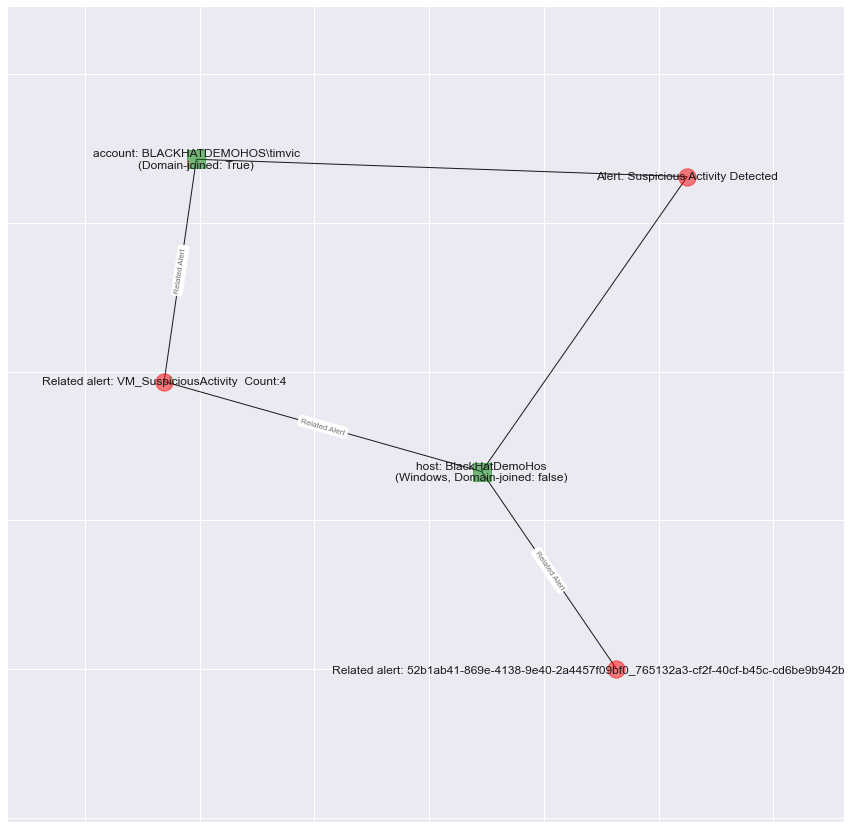

In [26]:
alert = SecurityAlert(rel_alert_select.selected_alert)
grph = create_alert_graph(alert)
full_grph = add_related_alerts(related_alerts, grph)
nbdisplay.draw_alert_entity_graph(full_grph, width=15)

### Logon Sessions
Logon events are key to understanding any host based activity. We have previously used MSTICpy's [timeline feature](https://msticpy.readthedocs.io/en/latest/visualization/EventTimeline.html) to display value based data such as our Azure virtual machine metrics, as well as discrete data such as alerts, however we can also use it to display multiple types of discrete data on the same timeline. This is particularly useful for Windows logon events where we plot different logon types (interactive, network, etc.) in different horizontal series.

In [30]:
# Acquire data using a built in query
host_logons = qry_prov.WindowsSecurity.list_host_logons(start=start,end=end, host_name=host_name)

# Display timeline
tooltip_cols = ["TimeGenerated", "Account", "LogonType", 'TimeGenerated']
nbdisplay.display_timeline(
    data=host_logons, 
    alert=rel_alert_select.selected_alert, 
    title="Host Logons", 
    source_columns = tooltip_cols, 
    group_by = "LogonType", 
    height=200
);

<IPython.core.display.Javascript object>

Loading BokehJS ...

When presented with a large number of events such as we have here its useful to cluster these into a more managable number of groups. MSTICpy contains [clustering features](https://msticpy.readthedocs.io/en/latest/msticpy.sectools.html?highlight=cluster_events#msticpy.sectools.eventcluster.dbcluster_events) that can be used against a number of data types. Once clustering is complete we use another [widget](https://msticpy.readthedocs.io/en/latest/msticpy.nbtools.html?highlight=SelectItem#msticpy.nbtools.nbwidgets.SelectItem) to let the user select the cluster they want to focus on.

In [31]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

# Create features from raw data
logon_features = host_logons.copy()
logon_features["AccountNum"] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
logon_features["TargetUserNum"] = host_logons.apply(lambda x: _string_score(x.TargetUserName), axis=1)
logon_features["LogonHour"] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

# run clustering
(clus_logons, _, _) = dbcluster_events(
    data=logon_features, 
    time_column="TimeGenerated", 
    cluster_columns=["AccountNum", "LogonType", "TargetUserNum"], 
    max_cluster_distance=0.0001
)

# Get distinct items from clustered set
dist_logons = clus_logons.sort_values("TimeGenerated")[
    ["TargetUserName", "TimeGenerated", "LastEventTime", "LogonType", "ClusterSize"]
]
dist_logons = dist_logons.apply(lambda x: (
        f"{x.TargetUserName}:    "
        f"(logontype {x.LogonType})   "
        f"timerange: {x.TimeGenerated} - {x.LastEventTime}    "
        f"count: {x.ClusterSize}"
    ),
    axis=1,
)
dist_logons = {v: k for k, v in dist_logons.to_dict().items()}

# Display list to choose from
def show_logon(idx):
    return nbdisplay.format_logon(pd.DataFrame(clus_logons.loc[idx]).T)

logon_wgt = nbwidgets.SelectItem(
    description="Select logon cluster to examine",
    item_dict=dist_logons,
    action=show_logon,
    height="200px", 
    width="100%", 
    auto_display=True
)

Account: timvicAccount Domain: BlackHatDemoHosLogon Time: 2020-07-10 18:27:49.790000+00:00Logon type: 10(RemoteInteractive)User Id/SID: S-1-5-21-3334416894-4278249820-3875274378-1006 SID S-1-5-21-3334416894-4278249820-3875274378-1006 is local machine or domain accountSubject (source) account: WORKGROUP/BlackHatDemoHos$Logon process: User32 Authentication: NegotiateSource IpAddress: 174.127.235.80Source Host: BlackHatDemoHosLogon status:


In [32]:
# We can reset our timeframe based on the selected cluster.
start = clus_logons.loc[logon_wgt.value]['FirstEventTime']
end = clus_logons.loc[logon_wgt.value]['LastEventTime']

### Process Tree
When investigating a host it is valuable to see the processes executed on the host, and the relationship between them. We can use the MSTICpy *ProcessTree* functionality to build and visualize [process trees](https://msticpy.readthedocs.io/en/latest/visualization/ProcessTree.html) from both Linux and Windows hosts.<br>

> Due to the volume of data potentially involved when looking at process events, it's important to have a focused time frame to look at. We use the MSTICpy [widget for selecting a time range](https://msticpy.readthedocs.io/en/latest/visualization/NotebookWidgets.html?highlight=QueryTime#querytime).

In [33]:
timescope = nbwidgets.QueryTime(units="hours", origin_time = start, max_before=12, max_after=24, before=0, after=3, auto_display=True)

HTML(value='<h4>Set query time boundaries</h4>')

In [34]:
proc_data = qry_prov.WindowsSecurity.list_host_processes(start=timescope.start,end=timescope.end, host_name=host_name)
p_tree = ptree.build_process_tree(proc_data, show_progress=True)
root_proc_sel = nbwidgets.SelectItem(
    description="Select root process to investigate process tree",
    item_list=ptree.get_roots(p_tree)['NewProcessName'].to_list(),
    height="200px",
    width="100%",
    auto_display=True)

<IPython.core.display.Javascript object>

{'Processes': 1154, 'RootProcesses': 14, 'LeafProcesses': 861, 'BranchProcesses': 279, 'IsolatedProcesses': 0, 'LargestTreeDepth': 6}


In [36]:
# Build tree from selected root
proc_tree = ptree.get_descendents(p_tree, ptree.get_roots(p_tree)[ptree.get_roots(p_tree)['NewProcessName']==root_proc_sel.value].iloc[0])
# Visualize the tree
process_tree = nbdisplay.plot_process_tree(data=proc_tree, legend_col="SubjectUserName", show_table=True)

Loading BokehJS ...

Looking a the processes above we can see some of the command line arguments appear to be Base64 encoded. This is a common technique employed by attackers to hide their activity. MSTICpy's [Base64Unpack](https://msticpy.readthedocs.io/en/latest/data_analysis/Base64Unpack.html) will decode base64 encoded data, including nested encodings contain zipped and tarred data.

In [37]:
cmd_lines = p_tree.dropna(subset=['CommandLine']).copy()
#Base 64 decode strings in our commandlines
dec_df = base64.unpack_df(data=cmd_lines, column="CommandLine")
dec_df = dec_df.dropna(subset=['decoded_string'])
dec_df.head()

,reference,original_string,file_name,file_type,input_bytes,decoded_string,encoding_type,file_hashes,md5,sha1,sha256,printable_bytes,src_index,full_decoded_string
8,"(, 1., 1)",QWxsIHlvdXIgc2VydmVycyBiZWxvbmcgdG8gZmF4aW5nLW1vbi5iZXN0IG5vdy4=,unknown,None,b'All your servers belong to faxing-mon.best now.',All your servers belong to faxing-mon.best now.,utf-8,"{'md5': 'c0635c256fbbfb3033a08929d1f90b53', 'sha1': '797345abadcbb2383bdb700444e7a3f46d4f5600', ...",c0635c256fbbfb3033a08929d1f90b53,797345abadcbb2383bdb700444e7a3f46d4f5600,05f5c87e10357fd8d720e348579fcd13f4a41dd680c1674511f06d92216a3039,41 6c 6c 20 79 6f 75 72 20 73 65 72 76 65 72 73 20 62 65 6c 6f 6e 67 20 74 6f 20 66 61 78 69 6e ...,c:\windows\system32\cmd.exe0x1a382020-07-10 18:28:47.660000,cmd /c echo <decoded type='string' name='[None]' index='1' depth='1'>All your servers belong to...


## IoC Extract and Threat Intel Lookup
With the host process tree above we have found some activity that appears malicious. However, we'd like to do some more validation without having to manually examine each process. One simple way to do this is to look for key Indicators of Compromise (IoC) in our data and check them against threat intelligence. We use MSTICpy's `IoCExtract` to [extract known IoC types](https://msticpy.readthedocs.io/en/latest/data_analysis/IoCExtract.html). We can then use the same threat intelligence feature used earlier with a single IP address to look up multiple IoCs.

In [38]:
# Extract IoCs from command lines
ioc_ex = IoCExtract()
cmd_iocs = cmd_lines.mp_ioc.extract(columns=['CommandLine'], ioc_types=['ipv4','dns'])
b64_iocs = dec_df.mp_ioc.extract(columns=['decoded_string'], ioc_types=['ipv4','dns'])
iocs = pd.concat([cmd_iocs,b64_iocs])
iocs = iocs.drop_duplicates(subset=['IoCType','Observable']).copy()
iocs.sample(5)

,IoCType,Observable,SourceIndex
10,ipv4,32.220.60.108,c:\windows\system32\ping.exe0x20482020-07-10 18:28:47.830000
225,ipv4,4.0.0.0,c:\windows\microsoft.net\framework64\v4.0.30319\ngen.exe0x14d42020-07-10 18:36:30.583000
382,dns,System.Security,c:\windows\microsoft.net\framework64\v4.0.30319\ngen.exe0x8402020-07-10 18:36:57.620000
359,dns,System.Management,c:\windows\microsoft.net\framework\v4.0.30319\ngen.exe0x18342020-07-10 18:36:56.767000
2,dns,microsoft.com,c:\windows\system32\cmd.exe0x26e42020-07-10 18:28:46.993000


Similar to the alert viewer widget used earlier MSTICpy has a viewer for threat intelligence results to make reviewing the output easier.
> Note: The full response details from the provider can be see in the collapsible `Raw Results` section

In [41]:
# TI Lookups
ti_resp = ti.lookup_iocs(data=iocs, obs_col="Observable")
select_ti = browse_results(ti_resp, severities=['high','warning'], height="200px")
select_ti

In [43]:
select_ti.value

('secure-ssl-sec.com', ['OTX'])

### Review the DNS Domain
We have appear to have identified a malicious domain to go with the IP address identified earlier in our investigation. In order to complete our investigation we want to get some context on this domain in the same way we did with the IP address. Again MSTICpy has a number of tools to help with this, including features to [validate a domain](https://msticpy.readthedocs.io/en/latest/getting_started/PackageSummary.html?highlight=screenshot#domain-utils) and [screenshot a URL](https://msticpy.readthedocs.io/en/latest/getting_started/PackageSummary.html?highlight=screenshot#domain-utils).

> Note: these tools use publicly-available services such as *abuse.ch* and *Browshot*

In [60]:
dom_name, _ = select_ti.value
dom_val = domain_utils.DomainValidator()
md(f"Is {dom_name} a valid domain? <b>{dom_val.validate_tld(dom_name)}</b>")
md(f"Is {dom_name} resolvable? <b>{dom_val.is_resolvable(dom_name)}</b>")
md(f"Is the TLS cert used by {dom_name} in abuse.ch's abuse list? <b>{dom_val.in_abuse_list(dom_name)[0]}</b>")

In [47]:
image_data = domain_utils.screenshot(dom_name)
with open('screenshot.png', 'wb') as f:
        f.write(image_data.content)

display(Image(filename='screenshot.png'))

msticpy.common.exceptions.MsticpyUserConfigError('No configuration found for Browshot',
                                                 'Please add a section to msticpyconfig.yaml:',
                                                 'DataProviders:',
                                                 '  Browshot:',
                                                 '    Args:',
                                                 '      AuthKey: {your_auth_key}')

<font color='blue'>[ian comment] I think it would be good to have a conclusion of some sort in the notebook, even if we don't show this in the video. Just for people who look at the notebook independently.

# Resources
## msticpy
- msticpy Github https://github.com/Microsoft/msticpy
- msticpy Docs https://msticpy.readthedocs.io/en/latest/
- msticpy Release Blog https://medium.com/@msticmed

## msticpy maintainers:
- Ian Hellen [@ianhellen](https://twitter.com/ianhellen)
- Pete Bryan [@MSSPete](https://twitter.com/MSSPete)
- Ashwin Patil [@ashwinpatil](https://twitter.com/ashwinpatil)

## Other useful stuff
- Azure Sentinel Github Notebooks https://github.com/Azure/Azure-Sentinel/Notebooks/tree/master
  - (Samples with data in Sample-Notebooks folder)
- Azure Sentinel Tech Community Blogs https://aka.ms/AzureSentinelBlog